In [49]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import gower

In [50]:
#WHERE LEAD_STATUS IN ('OTB', 'Decline')

In [51]:
def data_access():
    project_id="model-lookups-mysql"
    client=bigquery.Client(project=project_id)
    query="""SELECT * FROM `model-lookups-mysql.leads_dmp.lewis_mlm_live`WHERE LEAD_STATUS IN ('OTB', 'Decline') and deceased = 0 and dma_sensitive = 0 and bf_sensitive = 0 and credit_score >= 200 """
    job=client.query(query)
    data=job.to_dataframe()
    return data
def select_columns(data):
    sc=['calculated_gender', 'calculated_age','have_personal_loan' ,
     'is_govt_employed', 'is_employed','credit_score', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview']
    data=data[sc]
    cat_col_no_object=['have_personal_loan', 'is_govt_employed', 'is_employed', 
    'is_home_owners', 'is_car_owners' , 'is_under_debtreview']
    data[cat_col_no_object]= data[cat_col_no_object].astype(str)
    others=[  'is_govt_employed', 'is_home_owners', 'is_car_owners' , 'is_under_debtreview','have_personal_loan']
    recoding_others={'0': 'No', '1':'Yes'}
    data[others]=data[others].replace(recoding_others)
    recoding_employed={'0': 'Unknown/Unemployed', '1':'Employed'}   
    data['is_employed']=data['is_employed'].replace(recoding_employed)
    data = data[data['calculated_gender'] != 'U']
    return data
def remove_outliers(data):
    for column in data.select_dtypes(include=['number']).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data
cat_cols=['calculated_gender','have_personal_loan' ,
     'is_govt_employed', 'is_employed', 'is_home_owners', 
     'is_car_owners' , 'is_under_debtreview']
def encoded_data(data):
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False)
    one = encoder.fit_transform(data[cat_cols])
    one_df = pd.DataFrame(one, columns=encoder.get_feature_names_out(cat_cols), index=data.index)
    encoded = pd.concat([data, one_df], axis=1)
    encoded = encoded.drop(data[cat_cols], axis=1)
    return encoded

scaler = StandardScaler()
def scaled_data(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.fit_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data

def transform_back(data):
    num_cols = ["credit_score", "calculated_age"]
    numerical_data = scaler.inverse_transform(data[num_cols])
    data[num_cols] = numerical_data
    return data

In [52]:
data=data_access()

In [53]:
selected_data=select_columns(data)

In [54]:
selected_data

,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview
0,M,32,Yes,No,Employed,650,No,Yes,No
1,F,32,No,No,Unknown/Unemployed,614,Yes,No,No
2,F,34,No,No,Unknown/Unemployed,650,No,No,No
3,M,35,No,No,Employed,603,No,No,No
4,M,38,No,No,Unknown/Unemployed,524,No,No,No
...,...,...,...,...,...,...,...,...,...
243111,M,43,No,No,Unknown/Unemployed,584,No,No,Yes
243112,F,45,Yes,No,Unknown/Unemployed,652,No,Yes,No
243113,F,46,No,No,Unknown/Unemployed,665,No,No,No
243114,M,50,No,No,Employed,561,No,Yes,No


In [55]:
data_clean=remove_outliers(selected_data)

In [56]:
data_clean

,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview
0,M,32,Yes,No,Employed,650,No,Yes,No
1,F,32,No,No,Unknown/Unemployed,614,Yes,No,No
2,F,34,No,No,Unknown/Unemployed,650,No,No,No
3,M,35,No,No,Employed,603,No,No,No
4,M,38,No,No,Unknown/Unemployed,524,No,No,No
...,...,...,...,...,...,...,...,...,...
243110,F,42,No,No,Unknown/Unemployed,558,No,No,No
243111,M,43,No,No,Unknown/Unemployed,584,No,No,Yes
243112,F,45,Yes,No,Unknown/Unemployed,652,No,Yes,No
243113,F,46,No,No,Unknown/Unemployed,665,No,No,No


In [57]:
encode=encoded_data(data_clean)

In [58]:
scaled_data=scaled_data(encode)

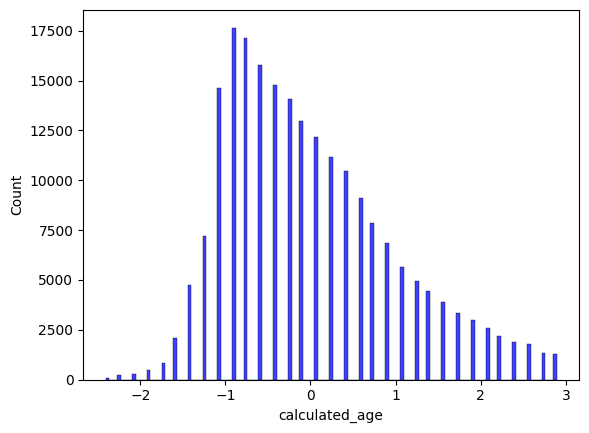

In [59]:
plot=sns.histplot(scaled_data['calculated_age'], color='b')

In [60]:
scaled_data

,calculated_age,credit_score,calculated_gender_F,calculated_gender_M,have_personal_loan_No,have_personal_loan_Yes,is_govt_employed_No,is_govt_employed_Yes,is_employed_Employed,is_employed_Unknown/Unemployed,is_home_owners_No,is_home_owners_Yes,is_car_owners_No,is_car_owners_Yes,is_under_debtreview_No,is_under_debtreview_Yes
0,-1.081617,0.863143,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,-1.081617,0.149927,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,-0.750497,0.863143,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.584937,-0.068000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.088258,-1.633112,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243110,0.573982,-0.959520,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
243111,0.739542,-0.444419,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
243112,1.070662,0.902766,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
243113,1.236221,1.160317,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


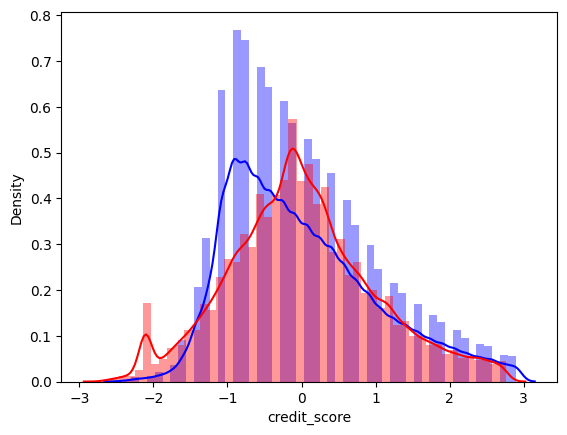

In [61]:
plot=sns.distplot(scaled_data['calculated_age'], color='b')
plot=sns.distplot(scaled_data['credit_score'], color='r')

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=5, n_init=10, tol=0.0001, algorithm='lloyd', copy_x=True, random_state=0)
kmeans.fit(scaled_data)
clusters = kmeans.predict(scaled_data)
silhouette = silhouette_score(scaled_data, clusters)
print(f'Silhouette Score: {silhouette}')


Silhouette Score: 0.17806886850182674


In [ ]:
import joblib
joblib.dump(kmeans, '/Users/senelisiwemuradzikwa/Desktop/Offernet/Client/Lewis/v2/kmeans_model.pkl')

['/Users/senelisiwemuradzikwa/Desktop/Offernet/Client/Lewis/v2/kmeans_model.pkl']

In [ ]:
clusters

array([0, 2, 0, ..., 0, 1, 1], dtype=int32)

In [ ]:
data_clean.insert(0, "Clusters", clusters, True)
data_clean

,Clusters,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview
0,0,M,33,No,No,Unknown/Unemployed,615,No,No,No
1,2,F,33,Yes,No,Unknown/Unemployed,704,Yes,Yes,No
2,0,M,33,No,No,Unknown/Unemployed,606,No,No,No
3,2,F,35,Yes,No,Employed,632,No,No,No
4,2,F,38,Yes,No,Employed,607,No,No,No
...,...,...,...,...,...,...,...,...,...,...
242649,2,F,37,No,No,Unknown/Unemployed,628,No,No,No
242650,0,M,40,No,No,Unknown/Unemployed,591,No,No,No
242651,0,F,42,No,No,Unknown/Unemployed,603,No,No,No
242652,1,M,47,Yes,No,Unknown/Unemployed,581,No,No,No


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')


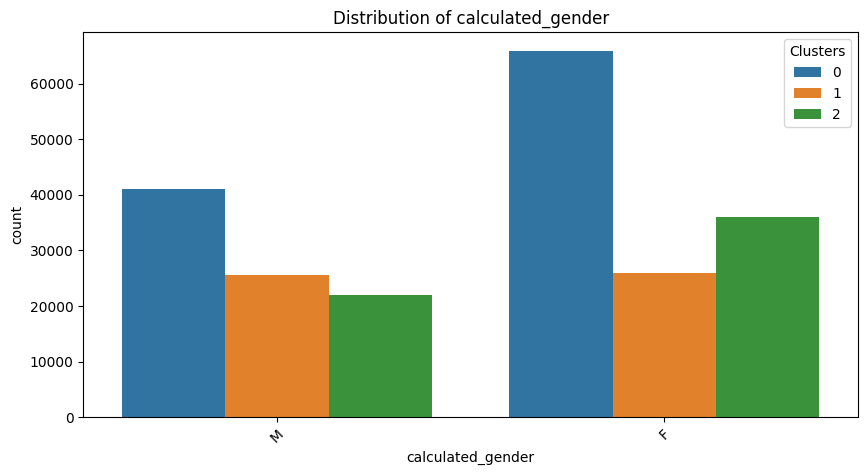

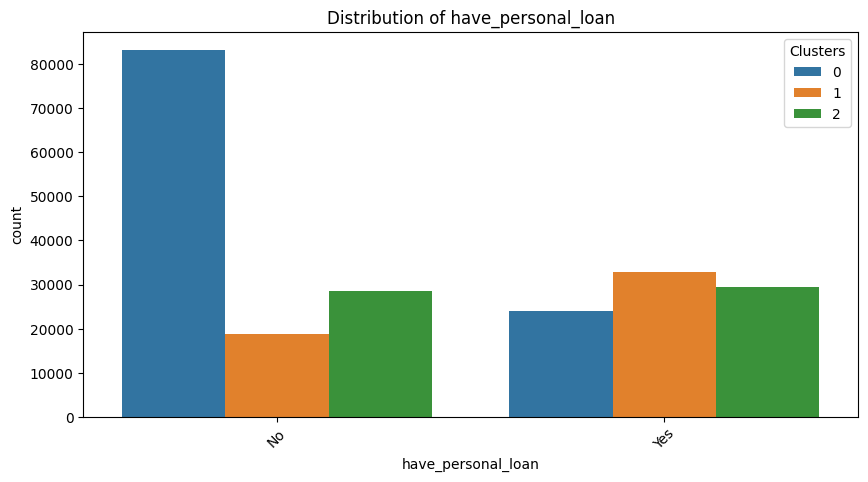

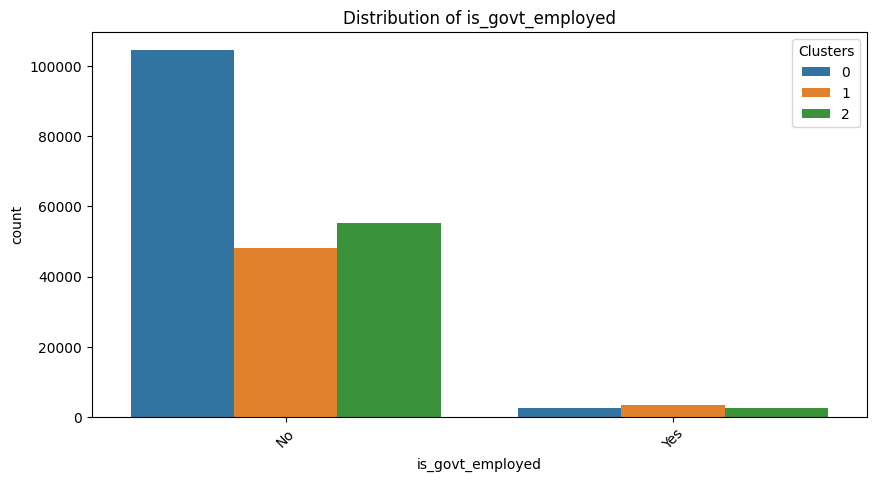

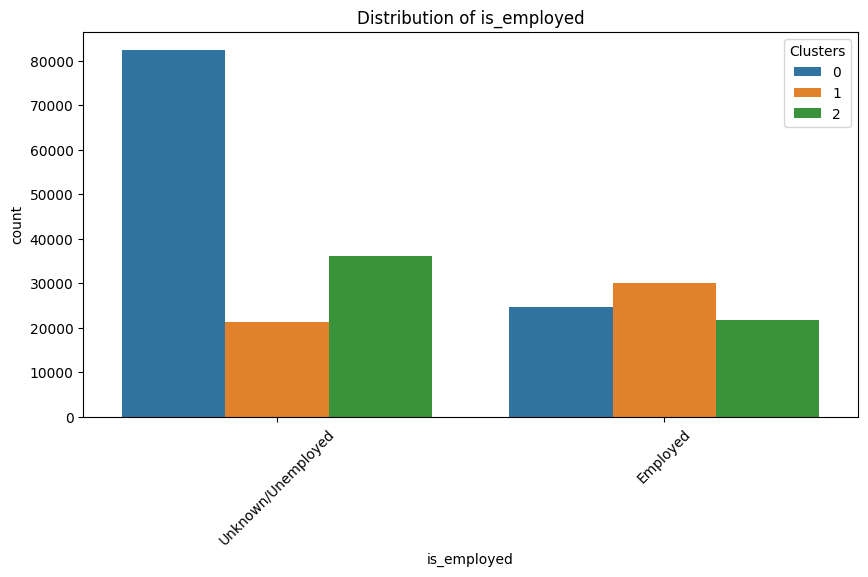

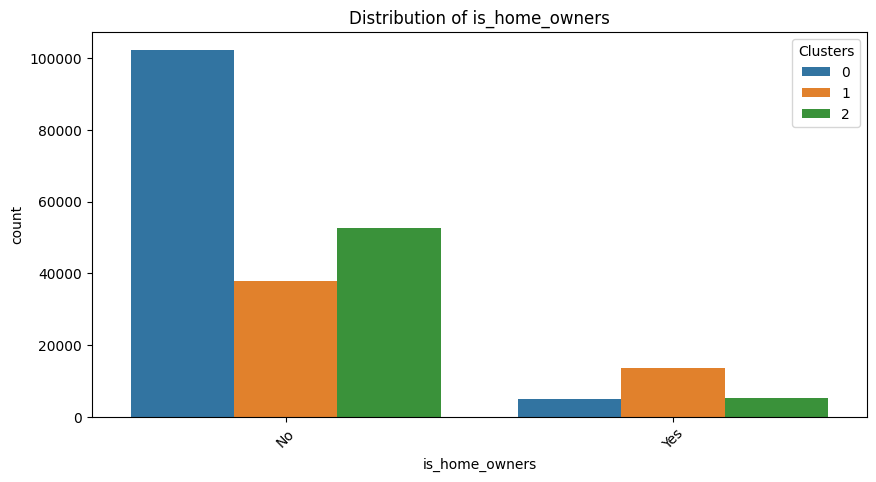

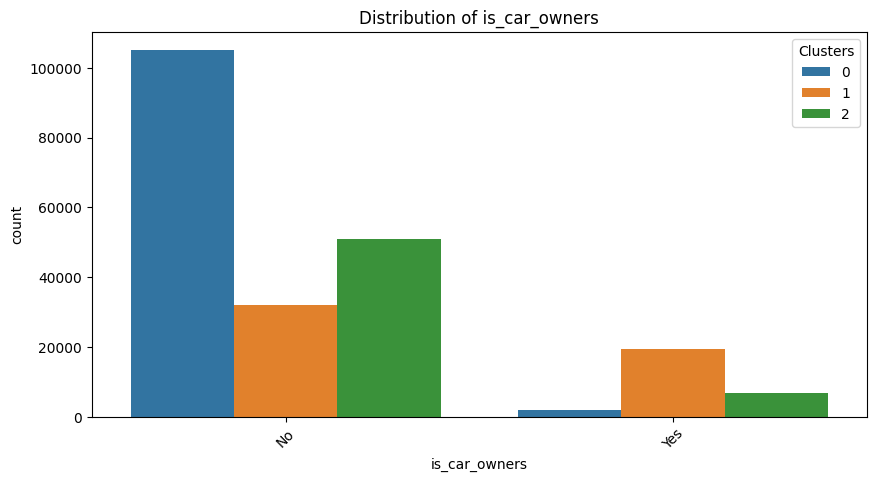

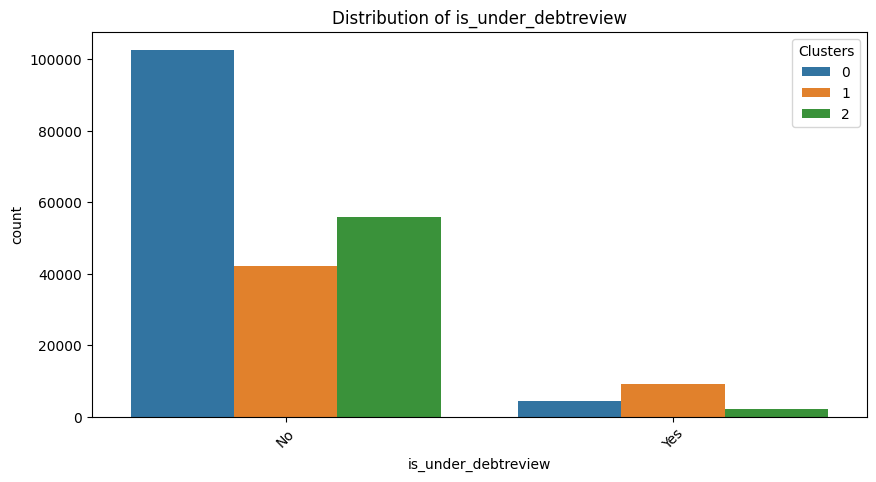

In [ ]:
categorical_cols = data_clean.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col,hue='Clusters' ,data=data_clean)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

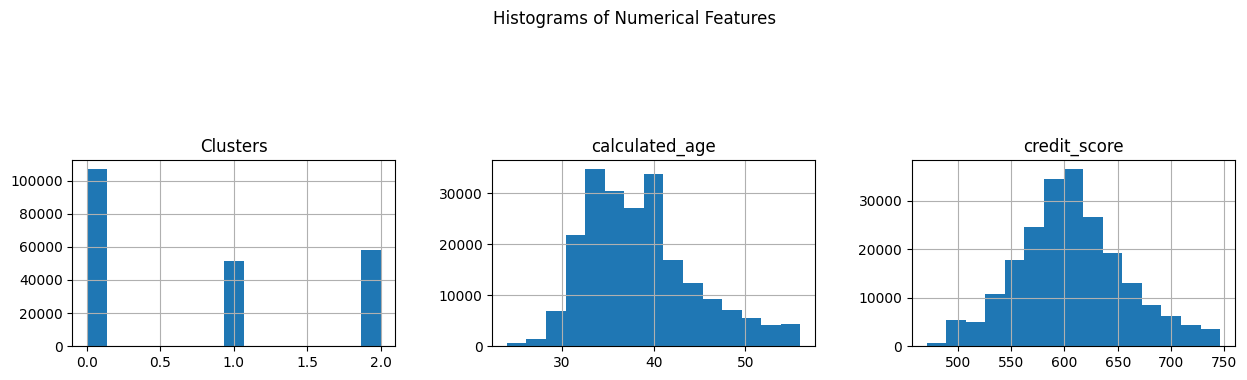

In [ ]:
data_clean.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [ ]:
filtered_data_0 = data_clean[data_clean['Clusters'] == 0]

In [ ]:
filtered_data_0

,Clusters,calculated_gender,calculated_age,have_personal_loan,is_govt_employed,is_employed,credit_score,is_home_owners,is_car_owners,is_under_debtreview
0,0,M,33,No,No,Unknown/Unemployed,615,No,No,No
2,0,M,33,No,No,Unknown/Unemployed,606,No,No,No
7,0,M,40,Yes,No,Unknown/Unemployed,500,Yes,No,Yes
8,0,F,42,No,No,Unknown/Unemployed,564,No,No,No
9,0,F,42,No,No,Unknown/Unemployed,564,No,No,No
...,...,...,...,...,...,...,...,...,...,...
242638,0,F,41,Yes,No,Unknown/Unemployed,570,No,No,No
242644,0,F,30,No,No,Unknown/Unemployed,605,No,No,No
242648,0,F,37,Yes,No,Employed,500,Yes,No,Yes
242650,0,M,40,No,No,Unknown/Unemployed,591,No,No,No


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    61.63
M    38.37
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
No     77.6
Yes    22.4
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     97.61
Yes     2.39
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Unknown/Unemployed    76.98
Employed              23.02
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
No     95.39
Yes     4.61
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
No     98.07
Yes     1.93
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     95.74
Yes

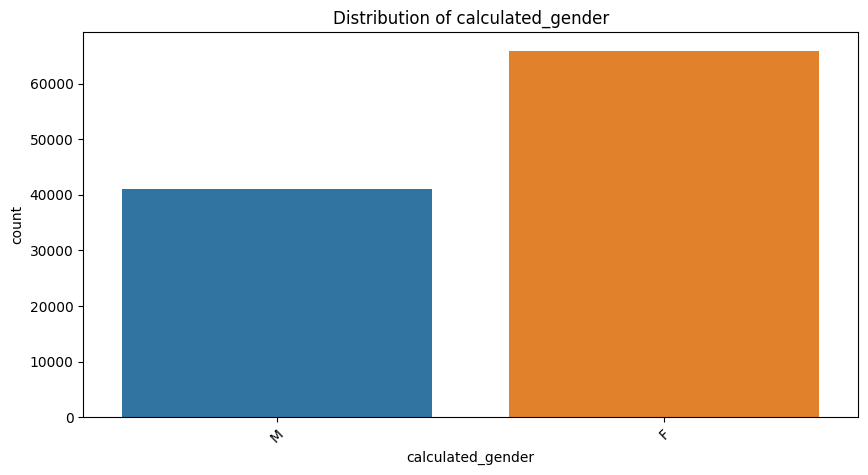

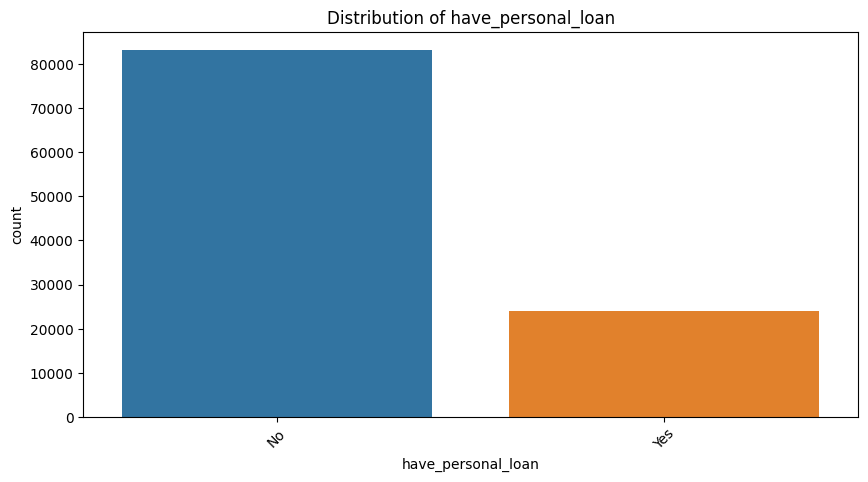

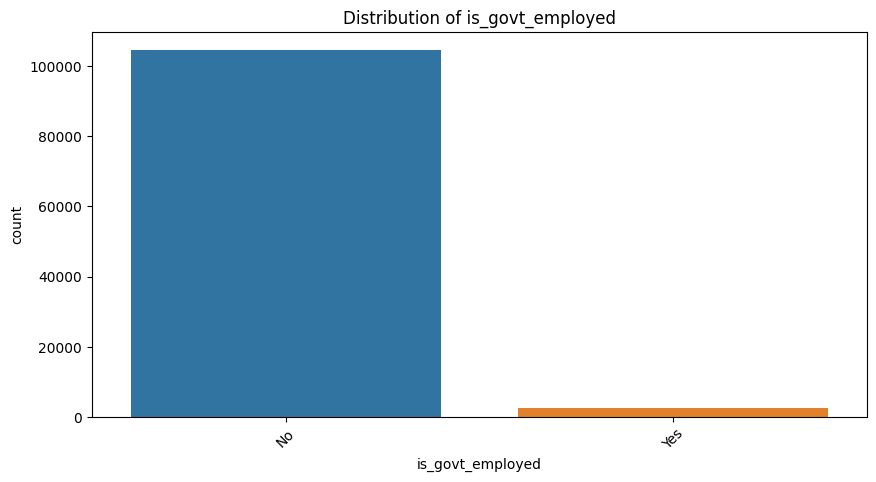

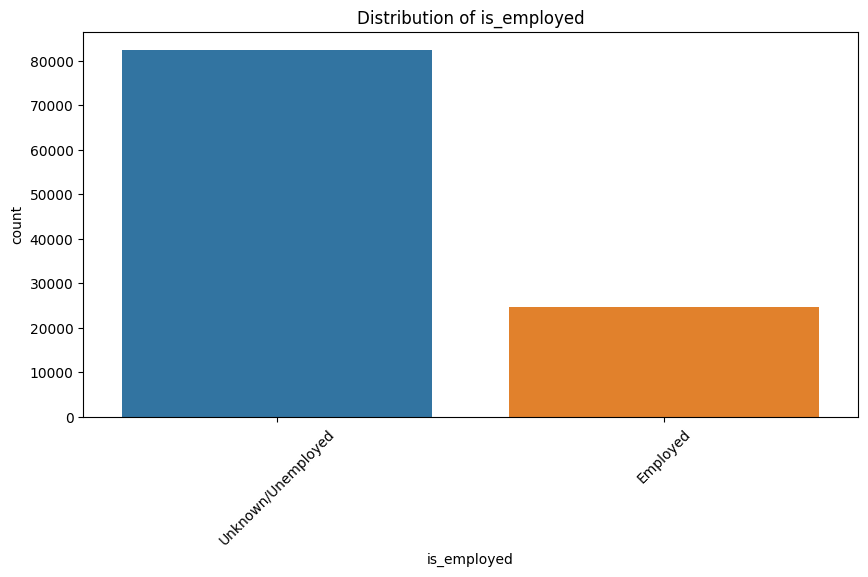

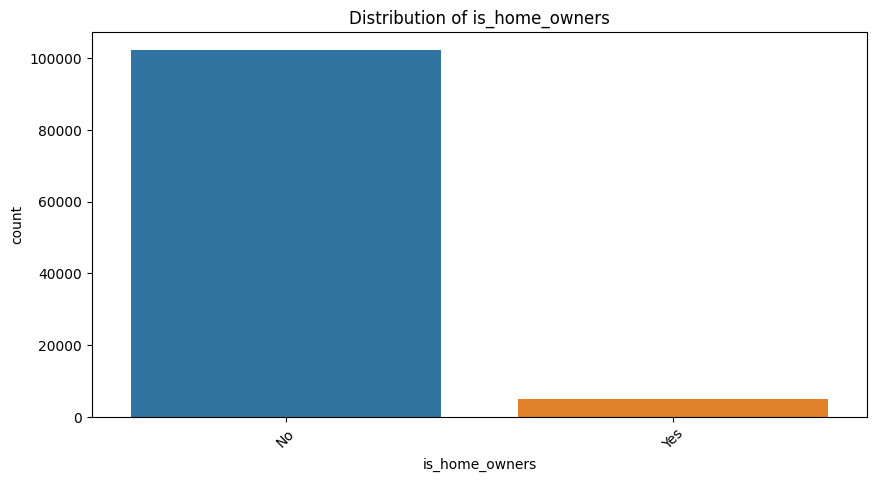

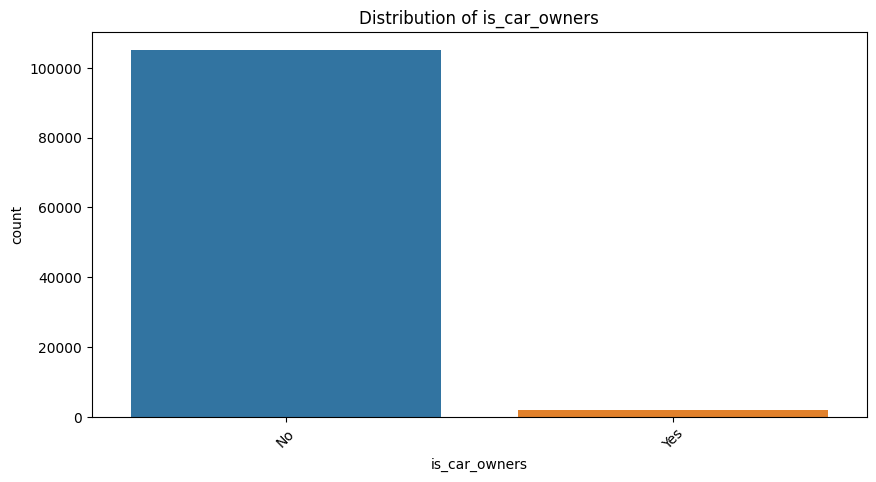

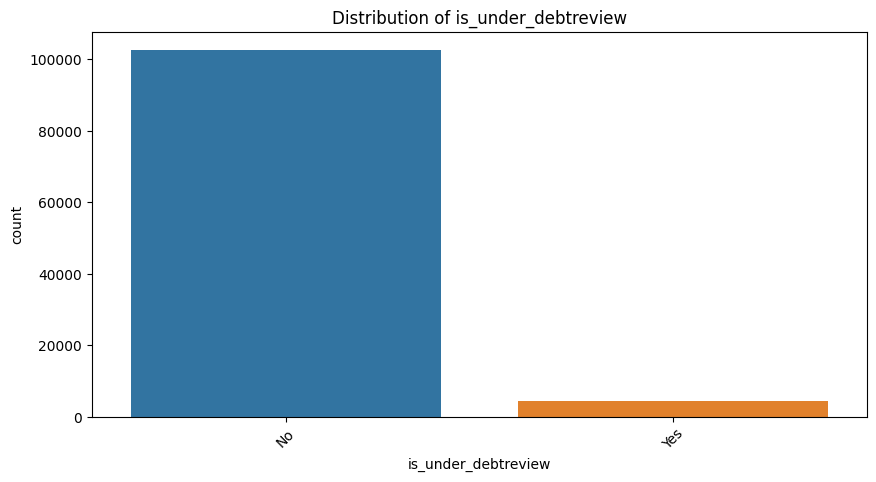

In [ ]:
categorical_cols = filtered_data_0.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_0[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_0)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show

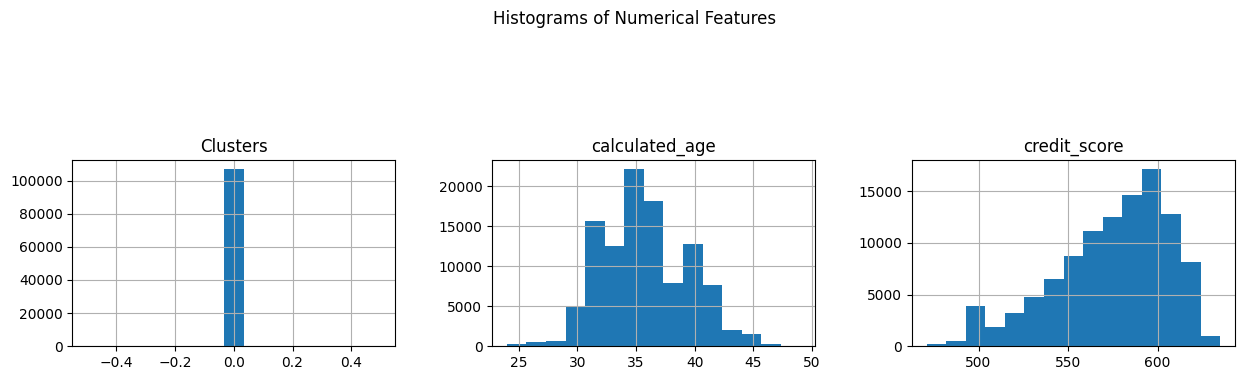

In [ ]:
filtered_data_0.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [ ]:
filtered_data_0.describe()

,Clusters,calculated_age,credit_score
count,107034.0,107034.0,107034.0
mean,0.0,35.582824,574.663462
std,0.0,3.639417,32.099209
min,0.0,24.0,471.0
25%,0.0,33.0,555.0
50%,0.0,35.0,581.0
75%,0.0,38.0,600.0
max,0.0,49.0,635.0


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    61.63
M    38.37
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
No     77.6
Yes    22.4
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     97.61
Yes     2.39
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Unknown/Unemployed    76.98
Employed              23.02
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
No     95.39
Yes     4.61
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
No     98.07
Yes     1.93
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     95.74
Yes

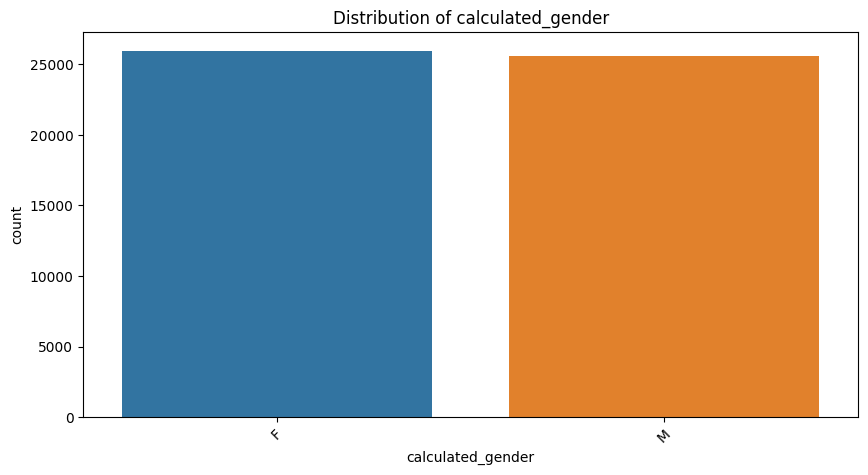

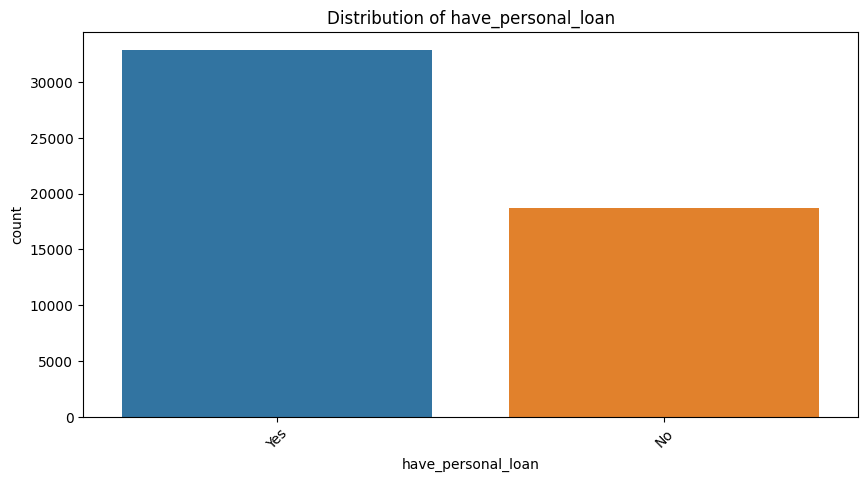

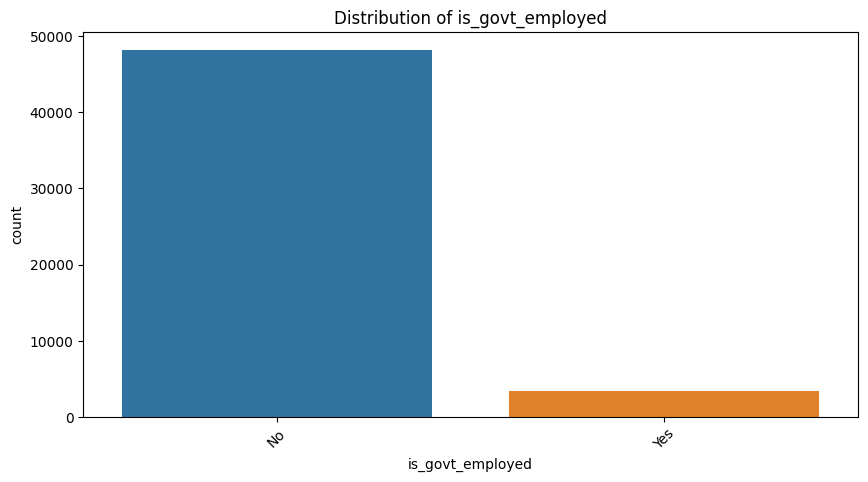

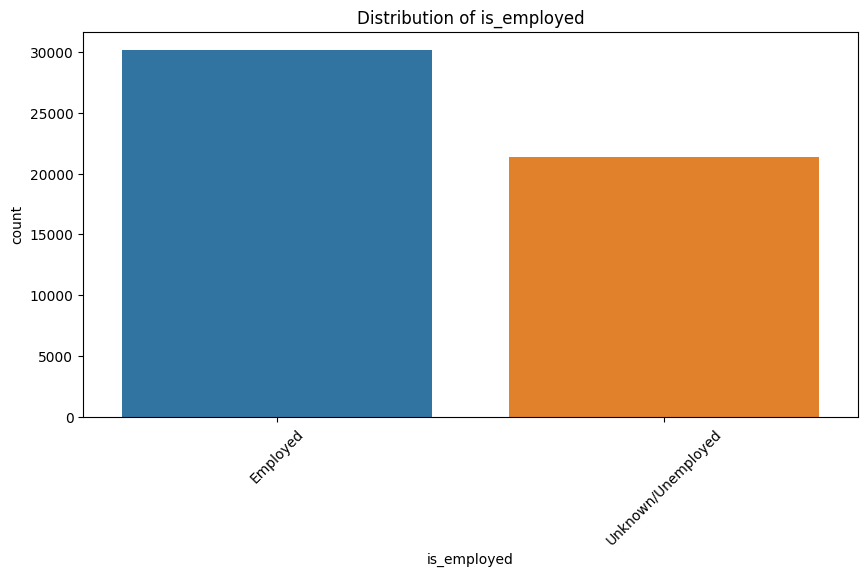

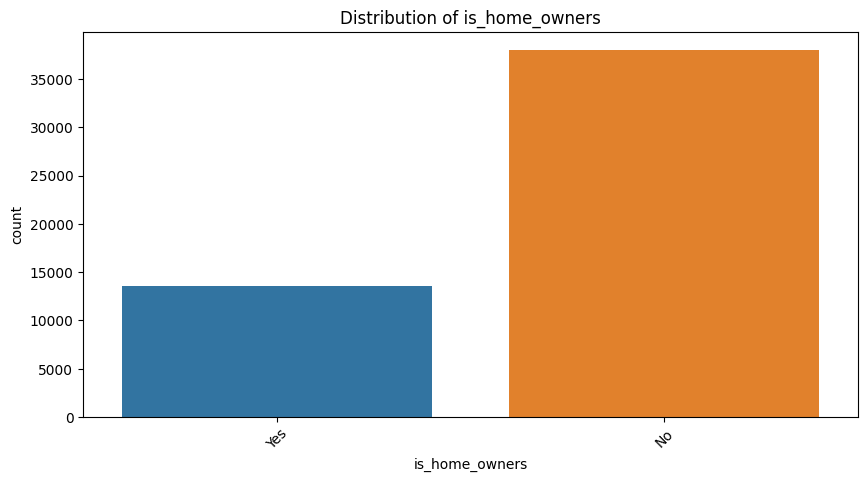

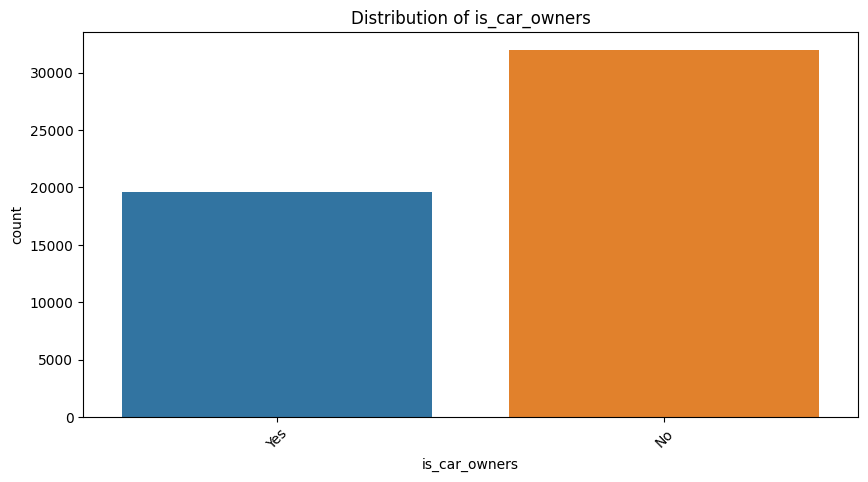

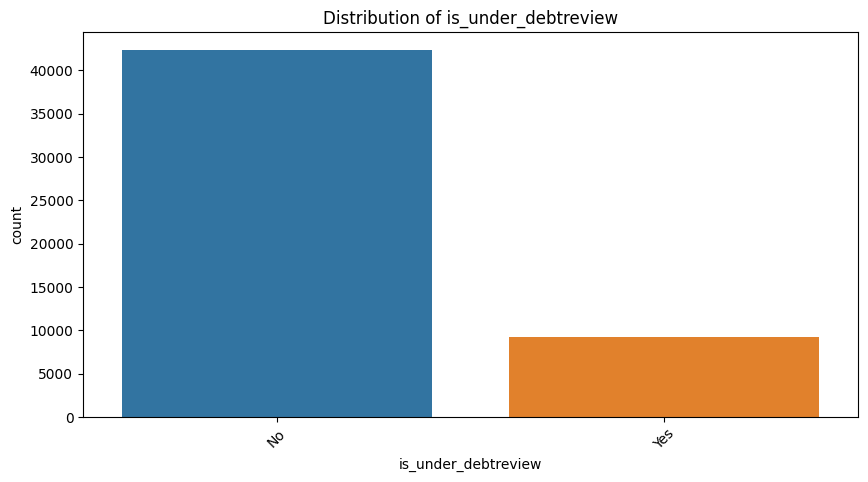

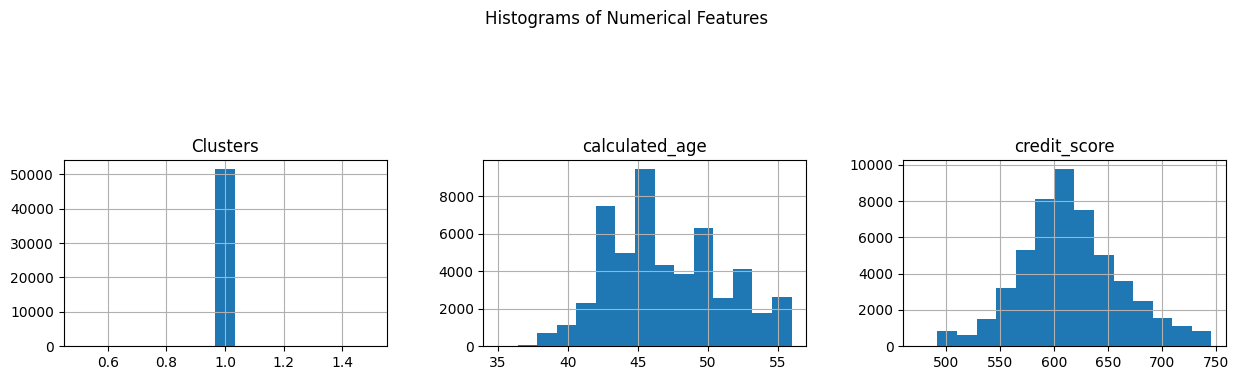

In [ ]:
filtered_data_1 = data_clean[data_clean['Clusters'] == 1]
categorical_cols = filtered_data_1.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_0[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_1)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show

filtered_data_1.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [ ]:
filtered_data_1.describe()

,Clusters,calculated_age,credit_score
count,51544.0,51544.0,51544.0
mean,1.0,46.925869,615.80698
std,0.0,4.160833,46.895546
min,1.0,35.0,474.0
25%,1.0,44.0,587.0
50%,1.0,46.0,613.0
75%,1.0,50.0,643.0
max,1.0,56.0,746.0


Categorical columns: Index(['calculated_gender', 'have_personal_loan', 'is_govt_employed',
       'is_employed', 'is_home_owners', 'is_car_owners',
       'is_under_debtreview'],
      dtype='object')

Value counts of column calculated_gender:
calculated_gender
F    61.63
M    38.37
Name: proportion, dtype: float64

Value counts of column have_personal_loan:
have_personal_loan
No     77.6
Yes    22.4
Name: proportion, dtype: float64

Value counts of column is_govt_employed:
is_govt_employed
No     97.61
Yes     2.39
Name: proportion, dtype: float64

Value counts of column is_employed:
is_employed
Unknown/Unemployed    76.98
Employed              23.02
Name: proportion, dtype: float64

Value counts of column is_home_owners:
is_home_owners
No     95.39
Yes     4.61
Name: proportion, dtype: float64

Value counts of column is_car_owners:
is_car_owners
No     98.07
Yes     1.93
Name: proportion, dtype: float64

Value counts of column is_under_debtreview:
is_under_debtreview
No     95.74
Yes

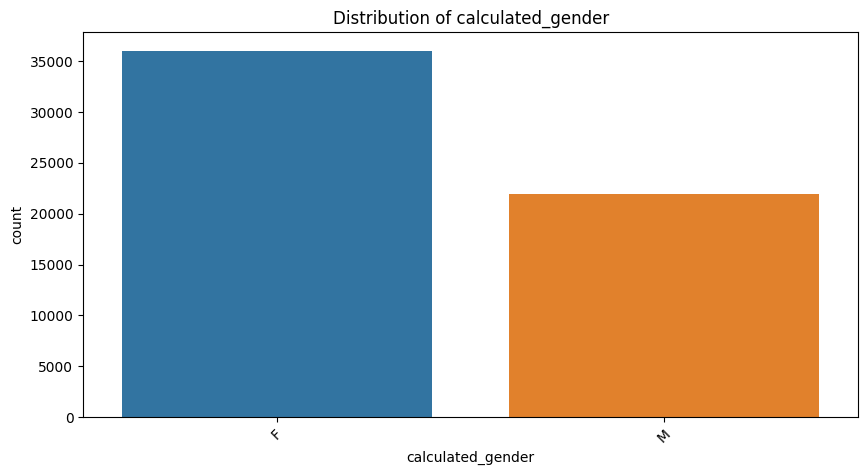

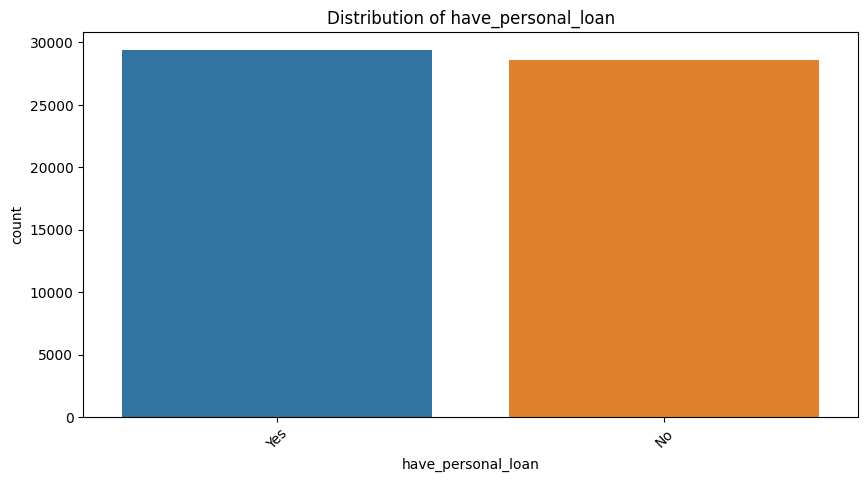

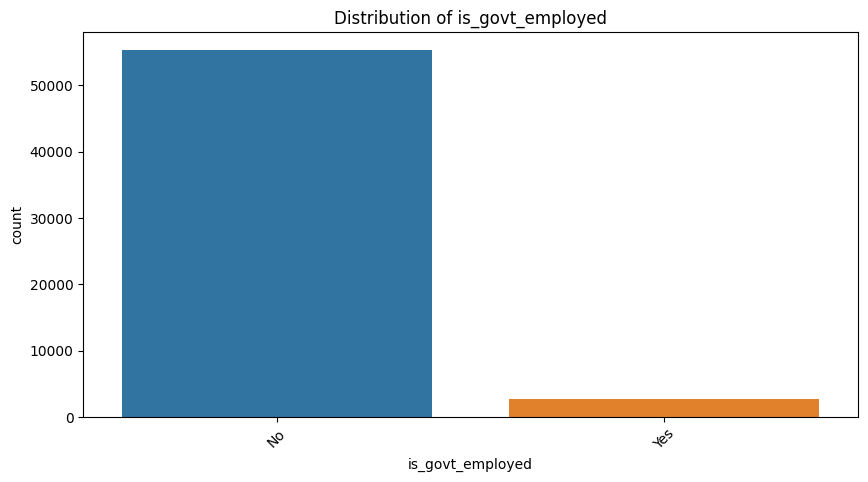

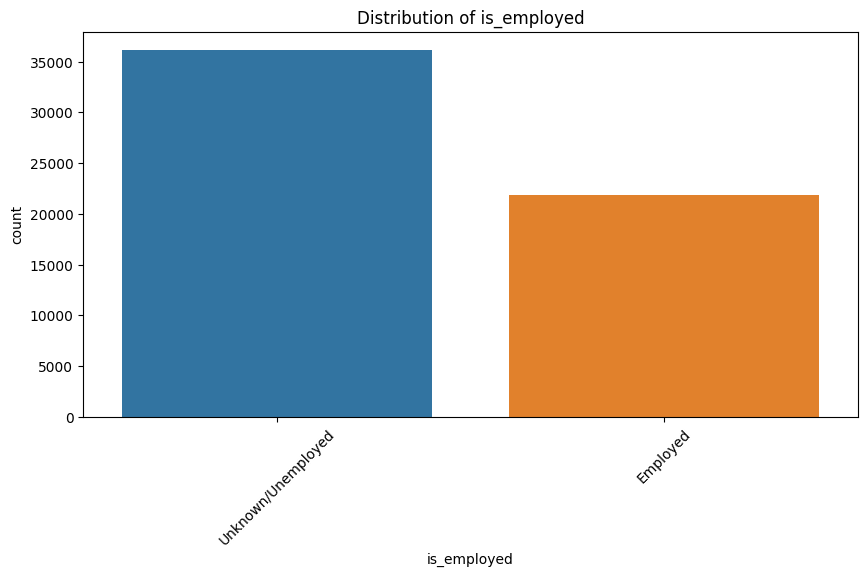

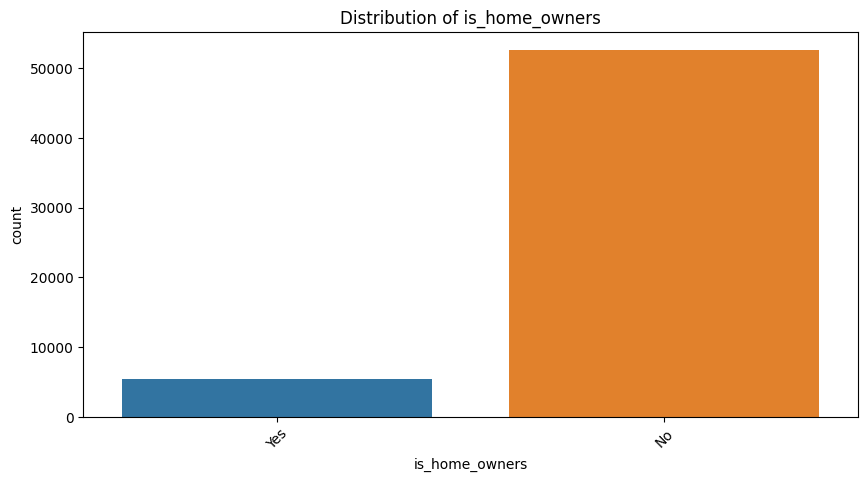

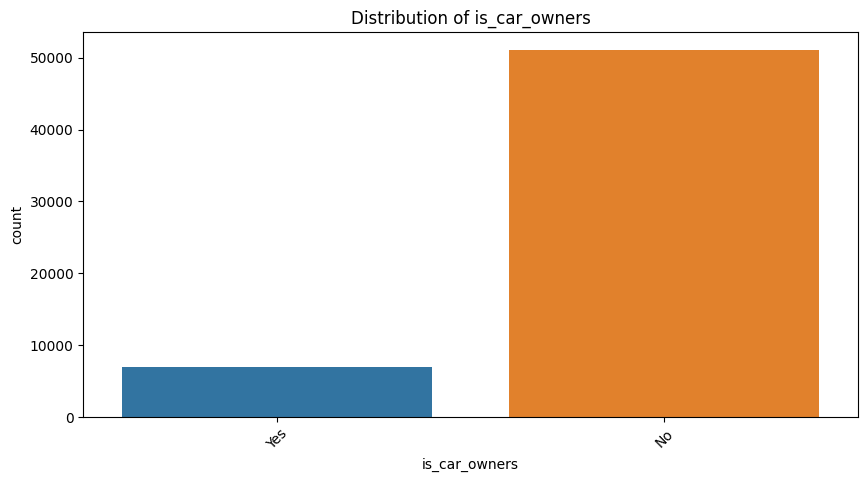

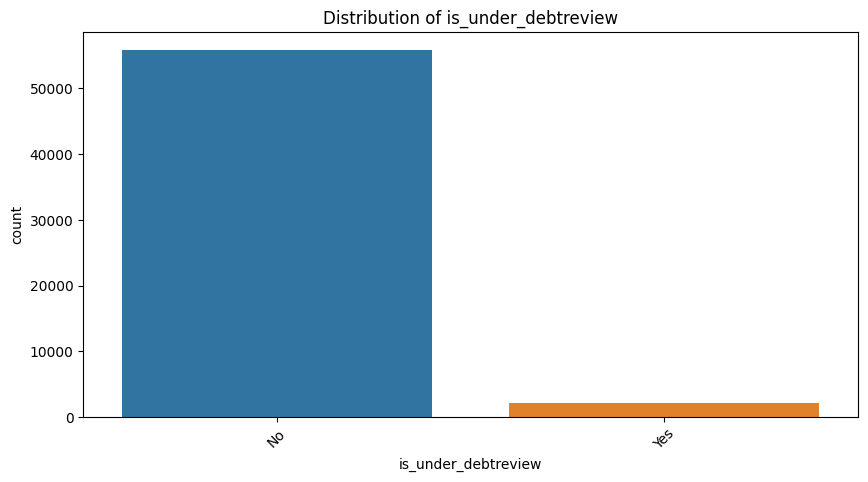

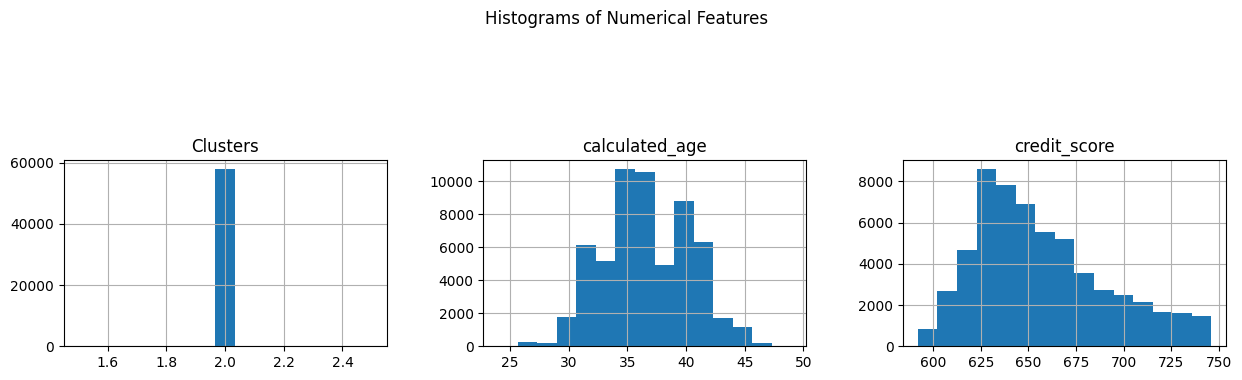

In [ ]:
filtered_data_2 = data_clean[data_clean['Clusters'] == 2]
categorical_cols = filtered_data_2.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols)
for col in categorical_cols:
    print(f"\nValue counts of column {col}:")
    print((filtered_data_0[col].value_counts(normalize=True) * 100).round(2))  # Round to two decimal places
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=filtered_data_2)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show

filtered_data_2.hist(bins=15, figsize=(15, 15), layout=(5, 3))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [ ]:
filtered_data_2.describe()

,Clusters,calculated_age,credit_score
count,57931.0,57931.0,57931.0
mean,2.0,36.514405,656.81383
std,0.0,3.694624,34.381543
min,2.0,24.0,592.0
25%,2.0,34.0,631.0
50%,2.0,36.0,649.0
75%,2.0,39.0,678.0
max,2.0,49.0,746.0


In [ ]:
# cat_cols_indices = [scaled_data.columns.get_loc(c) for c in scaled_data.columns if c in cat_cols]
# elbow_scores = {}
# silhouette_scores = {}
# for k in range(2, 9):
#     kproto = KPrototypes(n_clusters=k, init='Cao',n_jobs=-1, max_iter=10, n_init=1, verbose=1, random_state=0)
#     clusters = kproto.fit_predict(scaled_data.values, categorical=cat_cols_indices)
#     elbow_scores[k] = kproto.cost_
#     distance_matrix = gower.gower_matrix(scaled_data)
#     silhouette = silhouette_score(distance_matrix, clusters, metric='precomputed')
#     silhouette_scores[k] = silhouette 
#     print(f'Silhouette Score (Gower): {silhouette}')
    
# plt.plot(list(elbow_scores.keys()), list(elbow_scores.values()), marker='o')
# plt.xlabel("Values of K")
# plt.ylabel("Cost")
# plt.title("Elbow Method for Optimal K")
# plt.show()

# plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
# plt.xlabel("Values of K")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Scores for Different Values of K")
# plt.show()